<a href="https://colab.research.google.com/github/anujbhandari2/ECS171-Final-Project/blob/main/Supervised_LSTM_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# All the imports that are needed for data manipulation, analysis, ML, and plotting
import os
import pandas as pd
import numpy as np
from numpy import array
import math
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
df = pd.read_csv('BTC-USD.csv')

View the types of data that we have and see what we can do with it

- Gather the shape
- Get datatypes of all the values
- Have the data described to us
- Check if there's any nulls/data we need to fix

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
print('Days: ', df.shape[0])
print('Columns: ', df.shape[1])

Days:  2713
Columns:  7


In [ ]:
df.dtypes

,0
Date,object
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03
mean,11311.041069,11614.292482,10975.555057,11323.914637,11323.914637,1.470462e+10
std,16106.428891,16537.390649,15608.572560,16110.365010,16110.365010,2.001627e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,606.396973,609.260986,604.109985,606.718994,606.718994,7.991080e+07
50%,6301.569824,6434.617676,6214.220215,6317.609863,6317.609863,5.098183e+09
75%,10452.399414,10762.644531,10202.387695,10462.259766,10462.259766,2.456992e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [ ]:
print(df.isnull().values.sum())
print(df.isnull().values.any())

0
False


In [ ]:
start_date=df.iloc[0, 0]
end_date=df.iloc[-1, 0]

print('Starting Date: ',start_date)
print('Ending Date: ',end_date)


Starting Date:  2014-09-17
Ending Date:  2022-02-19


Convert to datetime and filter to get dates from the whole dataset

We will use dates from September 17, 2014 to February 19, 2022.

We will be dropping the Adj Close and Volume columns because they will not be needed for LSTM training.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

all_dates = df.loc[(df['Date'] >= '2014-09-17') & (df['Date'] <= '2022-02-19')]

all_dates.drop(all_dates[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
0,2014-09-17,465.864014,468.174011,452.421997,457.334015
1,2014-09-18,456.859985,456.859985,413.104004,424.440002
2,2014-09-19,424.102997,427.834991,384.532013,394.795990
3,2014-09-20,394.673004,423.295990,389.882996,408.903992
4,2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...,...
2708,2022-02-15,42586.464844,44667.218750,42491.035156,44575.203125
2709,2022-02-16,44578.277344,44578.277344,43456.691406,43961.859375
2710,2022-02-17,43937.070313,44132.972656,40249.371094,40538.011719
2711,2022-02-18,40552.132813,40929.152344,39637.617188,40030.976563


In [ ]:
# Groups data by the month name and computes the average Open and Close prices.
# Reorders the months in chronological order.
monthly= all_dates.groupby(all_dates['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthly = monthly.reindex(new_order, axis=0)

In [ ]:
# Visualize the trends before we apply our LSTM

names = cycle(['Open','Close'])

fig = px.line(all_dates, x=all_dates.Date, y=[all_dates['Open'], all_dates['Close']],labels={'Date': 'Date','value':'Coin Price'})
fig.update_layout(title_text='Bitcoin Analysis Chart',legend_title_text='Key')

fig.show()

In [ ]:
# We're predicting for closing cost
closing = df[['Date','Close']]
print(closing.shape)

(2713, 2)


In [ ]:
# We will get everything from after January 1st
closing = closing[closing['Date'] > '2021-01-01']
# Copy so we can graph later
close_stock = closing.copy()
print("# of datapoints: ",closing.shape[0])

# of datapoints:  414


In [ ]:
close_stock.head()

,Date,Close
2299,2021-01-02,32127.267578
2300,2021-01-03,32782.023438
2301,2021-01-04,31971.914063
2302,2021-01-05,33992.429688
2303,2021-01-06,36824.363281


In [ ]:
fig = px.line(close_stock, x=close_stock.Date, y=close_stock.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_layout(title_text='Timeframe considered to predict closing price')
fig.show()

In [ ]:
# Get rid of Date before we standardize
del close_stock['Date']

In [ ]:
# Standardize the data that we have with Min Max Scalar to make values between 0 and 1
# Reshape the data
scaler = MinMaxScaler(feature_range=(0,1))
# Reshapes it into a column vector before applying scaling.
close_stock = scaler.fit_transform(np.array(close_stock).reshape(-1,1))

In [ ]:
print(close_stock.shape)

(414, 1)


In [ ]:
# Split train and test sets 70/30
train_size = int(len(close_stock)*0.70)
test_size = len(close_stock)-train_size

# Just take first 70% and subtract by the rest of the values
train_data,test_data = close_stock[0:train_size,:],close_stock[train_size:len(close_stock),:1]
print("Train Shape: ", train_data.shape)
print("Test Shape: ", test_data.shape)

Train Shape:  (289, 1)
Test Shape:  (125, 1)


LSTMs need to have sequential data formatted as input-output pairs or else it will not be shaped right


The way to do it is:
- Creates sequences of time_step length from data as input (X).
- Assign the next value as the output (y).
- Generate X_train, y_train from train_data.
- Generate X_test, y_test from test_data.

In [ ]:
# We need to convert the array of values that we have
# Make it into a dataset

def data(data, time_step=1):
    x, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        x.append(a)
        y.append(data[i + time_step, 0])
    return np.array(x), np.array(y)

time_step = 10
X_train, y_train = data(train_data, time_step)
X_test, y_test = data(test_data, time_step)

In [ ]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
# Reshape X_train and X_test so that each input sequence has one feature (closing price).
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

We're going to define a sequential Keras model. A Sequential model is the best for a  stack of layers where each layer has exactly one input and one output.

The LSTM(10, activation="relu") layer learns temporal dependencies, so it'll be better given time sequences.

The Dense(1) layer outputs a single predicted value (closing price).

Compiles the model using:
Loss function: mean_squared_error (MSE) for regression.
Optimizer: adam for efficient training.


In [ ]:
model = Sequential([
    Input(shape=(None, 1)),
    LSTM(10, activation="relu"),
    Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="adam")

Trains the LSTM model for 200 epochs.

Uses a batch size of 32 for optimization.

Validates the model on X_test and y_test after each epoch.

In [ ]:
# Stores the training history in past
past = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.1452 - val_loss: 0.1586
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1086 - val_loss: 0.1124
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0790 - val_loss: 0.0733
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0551 - val_loss: 0.0428
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0327 - val_loss: 0.0217
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0212 - val_loss: 0.0098
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0125 - val_loss: 0.0061
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0107 - val_loss: 0.0059
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0101 - val_loss: 0.0058
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0091 - val_loss: 0.0044
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0077 - val_lo

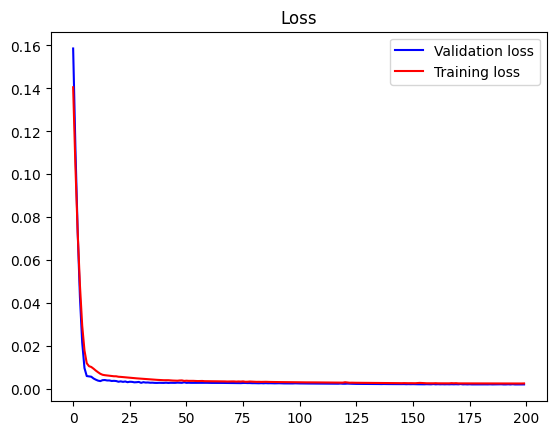

<Figure size 640x480 with 0 Axes>

In [ ]:
# here we want to plot to see the validation and training loss. We want to see if the model is improving or overfitting

loss = past.history['loss']
val_loss = past.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# Return predictions for both test and train sets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [ ]:
# Transform back to original form because we normalized the data earlier

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
og_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
og_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
# Evaluation metrices RMSE and MAE
print("Training Data Statistics")
print("RMSE: ", math.sqrt(mean_squared_error(og_ytrain,train_predict)))
print("MSE: ", mean_squared_error(og_ytrain,train_predict))
print("MAE: ", mean_absolute_error(og_ytrain,train_predict))
print("MAPE: ", mean_absolute_percentage_error(og_ytrain,train_predict))

Training Data Statistics
RMSE:  1933.1571084718814
MSE:  3737096.4060353655
MAE:  1452.4841220831836
MAPE:  0.033128264424438295


In [ ]:
print("Testing Data Statistics")
print("RMSE: ", math.sqrt(mean_squared_error(og_ytest,test_predict)))
print("MSE: ", mean_squared_error(og_ytest,test_predict))
print("MAE: ", mean_absolute_error(og_ytest,test_predict))
print("MAPE: ", mean_absolute_percentage_error(og_ytest,test_predict))

Testing Data Statistics
RMSE:  1772.4013819249833
MSE:  3141406.6586495903
MAE:  1340.349746438596
MAPE:  0.027458940131943253


The RMSE values are relatively close between train and test sets, which suggests the model isn't overfitting

The values are large due to squared scaling, but their relative similarity confirms no major overfitting as well

The relatively close values confirm that the model generalizes well

In [ ]:
print("Train variance regression score:", explained_variance_score(og_ytrain, train_predict))
print("Test variance regression score:", explained_variance_score(og_ytest, test_predict))

Train variance regression score: 0.9538432823399777
Test variance regression score: 0.9613847486552269


The model explains around 95.6% of variance in training data and 93.8% in test data, meaning it captures most trends relatively well

In [ ]:
print("Train data R2 score:", r2_score(og_ytrain, train_predict))
print("Test data R2 score:", r2_score(og_ytest, test_predict))

Train data R2 score: 0.9538418171402196
Test data R2 score: 0.9610798908220288


The model fits well since both scores are above 0.94

In [ ]:
print("Train data: ")
print("Train data MPD: ", mean_poisson_deviance(og_ytrain, train_predict))
print("Train data MGD: ", mean_gamma_deviance(og_ytrain, train_predict))

print("Test data:")

print("Test data MPD: ", mean_poisson_deviance(og_ytest, test_predict))
print("Test data MGD: ", mean_gamma_deviance(og_ytest, test_predict))

Train data: 
Train data MPD:  84.92328784547722
Train data MGD:  0.0019498958986070394
Test data:
Test data MPD:  59.885635509896815
Test data MGD:  0.0012550705873220053


MGD: Very small values indicate good predictions relative to actual values.
MPD: Lower values indicate better performance, and since the test MPD is lower than the train MPD, the model generalizes well.

In [ ]:
# we need to align the predicted values with their correct time periods for visualization
# shift the train predictions

# train_pred and test_pred are empty NumPy arrays initialized with NaN values so that predictions start at the correct index in the original time series.
look_back = time_step
train_pred = np.empty_like(close_stock)
train_pred[:, :] = np.nan
train_pred[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions
test_pred = np.empty_like(close_stock)
test_pred[:, :] = np.nan
test_pred[len(train_predict)+(look_back*2)+1:len(close_stock)-1, :] = test_predict

# The predictions are shifted forward by the number of look back steps
# Training predictions start after the lookback steps
# Testing predictions are shifted further so we can prevent overlap

plotdf = pd.DataFrame({'date': closing['Date'],
                       'og_close': closing['Close'],
                      'train_close': train_pred.reshape(1,-1)[0].tolist(),
                      'test_close': test_pred.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['og_close'],plotdf['train_close'],
                                          plotdf['test_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Close Prices')

fig.update_xaxes(showgrid=False)
fig.show()


In [ ]:
# Extract the last 'time_step' values from the test dataset as input for future predictions.
# Convert them into a list format for iterative predictions.
actual = test_data[len(test_data) - time_step:].reshape(1, -1)
sequence = list(actual)
sequence = sequence[0].tolist()

transformer_output = []
step = time_step
i = 0
pred_days = 3

while i < pred_days:

    if len(sequence) > time_step:

        actual = np.array(sequence[1:])  # Use last actual values
        actual = actual.reshape(1, -1)
        actual = actual.reshape((1, step, 1))

        yhat = model.predict(actual, verbose=0)  # prediction prediction
        sequence.extend(yhat[0].tolist())  # add prediction to input list
        sequence = sequence[1:]  # remove first element to keep sequence length constant

        transformer_output.extend(yhat.tolist())  # store prediction and increment by day
        i += 1

    else:
        actual = actual.reshape((1, step, 1))
        yhat = model.predict(actual, verbose=0)
        sequence.extend(yhat[0].tolist())

        transformer_output.extend(yhat.tolist())
        i += 1  # Increment day counter

print("Output of predicted next 3 days: ", len(transformer_output))


Output of predicted next 3 days:  3


In [ ]:
# forward stores the range [1, 2, ..., time_step] → Representing the last time_step (15) days.
# Used to index the last 15 days and next 3 days separately.

forward=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)

# Create empty numpy array and fill w NaN
indexed = np.empty((len(forward)+pred_days+1,1))
indexed[:] = np.nan
indexed = indexed.reshape(1,-1).tolist()[0]

# Store the past days and future day values
pastdaysval = indexed
nextvals = indexed

# Reshape them, and inverse transform
# Converts it back to original price range
pastdaysval[0:time_step+1] = scaler.inverse_transform(close_stock[len(close_stock)-time_step:]).reshape(1,-1).tolist()[0]
nextvals[time_step+1:] = scaler.inverse_transform(np.array(transformer_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

predicted_values = pd.DataFrame({
    'pred':pastdaysval,
    'future':nextvals
})

In [ ]:
names = cycle(['Last 15 days close price','Next 3 days predicted'])

fig = px.line(predicted_values,x=predicted_values.index, y=[predicted_values['pred'], predicted_values['future']], labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Last 15 days vs next 3 days', legend_title_text='Close Price')

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()
